In [1]:
import os
img_dir = '/images'

if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /images https://i.pinimg.com/originals/2b/17/2d/2b172d14b9352972de753e04b853bf9b.jpg
!wget --quiet -P /images https://i.pinimg.com/originals/93/06/e0/9306e02551a717e4af49917c9febd7a2.jpg

In [2]:
import tensorflow as tf

#Importing and displaying the Content Image and Style Image

#### We import preprocessing function from Keras, where each channel(BGR) is normalized by mean = [103.939, 116.779, 123.68].

In [3]:
from tensorflow.python.keras.preprocessing import image as preprocess_keras

#### We define a function ***path_to_image( )*** converts the image path to an actual Numpy array which can be used for further computation.

In [4]:
import numpy as np
from PIL import Image

def path_to_image(path, max_dimension):
  
  image = Image.open(path)

  #Keeping the aspect ratio constant, we limit the size of the image to max_dimension
  long = max(image.size)
  scale = max_dimension/long
  image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)
  
  image = preprocess_keras.img_to_array(image)

  #adding a batch dimension for the image 
  image = np.expand_dims(image, axis=0)

  return image

In [5]:
#Normalization of array values with the mean for Red, Green and Blue channels

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means  

## Displaying the Content Image and  Style Image
#### *We hope to "create" an image with the content of our content image, but with the style of the style image. **

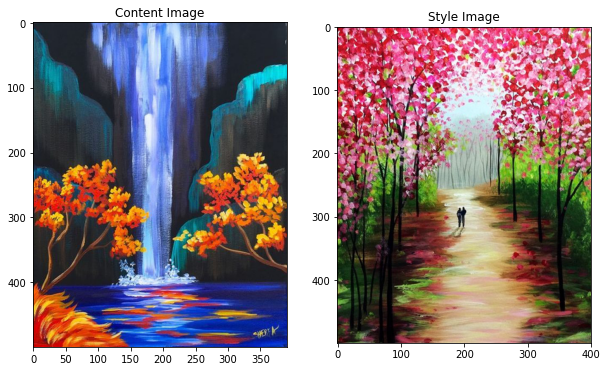

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
content_image = path_to_image('/images/2b172d14b9352972de753e04b853bf9b.jpg', 500).astype('uint8')
plt.imshow(np.squeeze(content_image, axis = 0).astype('uint8'))
plt.title('Content Image')

plt.subplot(1, 2, 2)
style_image = path_to_image('/images/9306e02551a717e4af49917c9febd7a2.jpg', 500).astype('uint8')
plt.imshow(np.squeeze(style_image, axis = 0).astype('uint8'))
plt.title('Style Image')

plt.show()

From [TensorFlow's Notebook on Style Transfer](https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb#scrollTo=I6XtkGK_YGD1)

Mathematically, we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$. 

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$

In [7]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

#### We import a VGG19 Model from Keras, which is pretained on ImageNet

In [8]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

#### Using the complex Convolutional Layers of VGG-19, we are able to extract specific features and characteristics of the style image (textures, gradients etc) and the content image as well.

In [9]:
#Using 5 Convolutional Layers to understand the style_image and 1 layer for the content_image
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layers = ['block5_conv2']

#### Next, we look forward to defining the model_output for our model, that shall include all of the features extracted from the defined style_layers and content_layers.

In [10]:
style_outputs = []

for layer in style_layers: 
    style_outputs.append(vgg.get_layer(layer).output)

content_outputs = []

for layer in content_layers: 
    content_outputs.append(vgg.get_layer(layer).output)

#Concating the outputs obtained from content and style images 
model_outputs = style_outputs + content_outputs

#### Using the Functional API of Keras, we're now able to define a pretrained model with the defined output.

In [11]:
from tensorflow.python.keras import models

vgg19_model = models.Model(vgg.input, model_outputs)

for layer in vgg19_model.layers:
    layer.trainable = False

#### Now, that we have defined the model through Keras API, we next evaluate the model by parsing the style_image and content_image through the model obtaining outputs in the different layers of model.

In [12]:
style_outputs = vgg19_model(style_image)
content_outputs = vgg19_model(content_image)

#### We break the outputs obtained through the model, in terms of the layers defined above in style_layers and content_layers.

In [13]:
style_features = []
for style_layer in style_outputs[:len(style_layers)]:
    style_features.append(style_layer[0])

content_features = []
for content_layer in content_outputs[len(style_layers):]:
    content_features.append(content_layer[0])

In [14]:
gram_style_features = []
for style_feature in style_features:
    gram_style_features.append(gram_matrix(style_feature))

#### We start our method of conversion by defining init_image as content_image, upon which updations and transformations will be done by the Model.

In [15]:
init_image = content_image
init_image = tf.Variable(init_image, dtype=tf.float32)

#### Adam Optimizer will be used in the process with the given hyperparameters.

In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.9, beta_2=0.999, epsilon=1e-1)

#### We also define a function ***deprocess_img( )*** which reverses the steps that we had taken for preprocessing, to give the output of an image.

In [17]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

#### To define the relative proportion of the style and content image in the mixed image, we define weights for both the quantities.

In [18]:
content_weight = 1e5
style_weight = 1e-2

#### We define a compute_loss( ) function that:

1. Feeds our initialized image through the pretrained model, giving us the content and style representations at the desired layers 

2. Calculates style and content losses through all the layers.

3. Provides total loss.



In [19]:
def compute_loss(vgg19_model, init_image, gram_style_features, content_features):


      #feeding init_image through vgg19_model and obtaining features
      model_outputs = vgg19_model(init_image)
      style_output_features = model_outputs[:len(style_layers)]
      content_output_features = model_outputs[len(style_layers):]



      #Calculating Loss for Style Layers
      style_score = 0

      #For equal contribution of each layer, we define the parameter
      weight_per_style_layer = 1.0 / float(len(style_layers))  
      
      for target_style, comb_style in zip(gram_style_features, style_output_features):
        
          height, width, channels = comb_style[0].get_shape().as_list()
          gram_style = gram_matrix(comb_style[0])
          
          #Style Score updation
          style_score = style_score + weight_per_style_layer * tf.reduce_mean(tf.square(gram_style - target_style))
        
      #Updation according to preference for specific image
      style_score *= style_weight




      #Calculating Loss for Content Layers
      content_score = 0

      #For equal contribution of each layer, we define the parameter
      weight_per_content_layer = 1.0 / float(len(content_layers))

      for target_content, comb_content in zip(content_features, content_output_features):

          #Content Score updation for every layer
          content_score = content_score + weight_per_content_layer * (tf.reduce_mean(tf.square(comb_content[0] - target_content)))


      #Updation according to preference for specific image
      content_score *= content_weight




      # Get total loss
      loss = style_score + content_score 

      return loss, style_score, content_score

#### For our final output, we initialize required_loss as infinite and required_image as None, which will be updated in following iterations.

In [20]:
required_loss = float('inf')
required_img =  None

#### Defining the number of iterations and the interval between displaying intermediate images

In [21]:
num_iterations = 1000
display_interval = 100

#### Iterating through epochs, updating init_image, and displaying intermediate images.

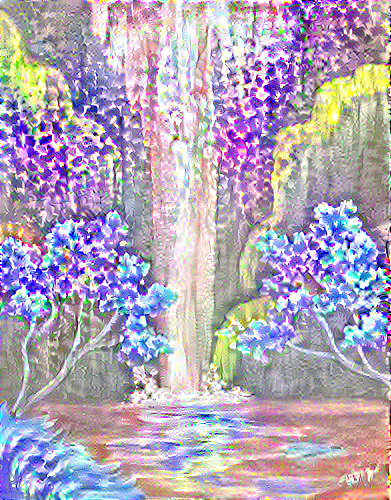

Iteration: 900


In [22]:
import IPython.display

for i in range(1000):

    with tf.GradientTape() as tape: 
        all_loss = compute_loss(vgg19_model, init_image, gram_style_features, content_features)
  
    total_loss = all_loss[0]
    loss, style_score, content_score = all_loss


    #Calculating gradients
    grads = tape.gradient(total_loss, init_image)

    #Updating init_image with calculated gradients
    adam_optimizer.apply_gradients([(grads, init_image)])
    
    #Making sure the R, G and B channel values remain in valid intervals 
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)


    if loss < required_loss:
      # Updating required loss and required image from total loss. 
      required_loss = loss
      required_img = deprocess_img(init_image.numpy())


    #displaying intermediate images on regular intervals
    if i % display_interval== 0:


      # Inverse regularization and conversion to image
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      
      #Displaying Image
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        


### Displaying the content image, style image & final output image

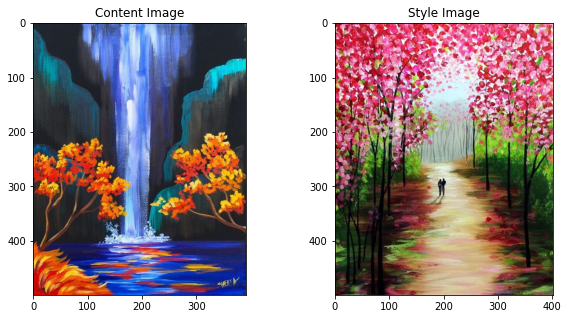

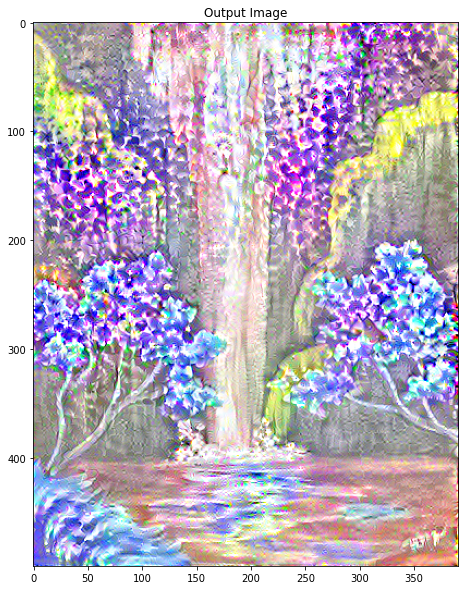

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(content_image, axis = 0).astype('uint8'))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_image, axis = 0).astype('uint8'))
plt.title('Style Image')

plt.figure(figsize=(10, 10))

plt.imshow(np.squeeze(required_img).astype('uint8'))
plt.title('Output Image')
plt.show()